In [29]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy.stats

In [2]:
filename = 'Experiment_July14_2023_QPU_FullSize_Xbasis_bit0.csv'

In [3]:
def fidelity_curves(JobAngles, BobFidelity, EveFidelity, degree):
    Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, degree))
    Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, degree))
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_Bob_Curve = Model_Bob(Thetas)
    Model_Eve_Curve = Model_Eve(Thetas)
    return Thetas, Model_Bob_Curve, Model_Eve_Curve

In [4]:
def get_data(filename):
    Completed_Job_Data = pd.read_csv(filename)

    JobAngles = Completed_Job_Data.iloc[:, 1]
    BobFidelity = Completed_Job_Data.iloc[:, 11]
    EveFidelity = Completed_Job_Data.iloc[:, 12]

    JobAngles = np.array(JobAngles)
    BobFidelity = np.array(BobFidelity)
    EveFidelity = np.array(EveFidelity)
    
    return  JobAngles, BobFidelity, EveFidelity

In [5]:
def error_rate_theory(theta):
    return 0.5 - 0.5*np.sin(2 * theta)

In [6]:
def fidelity_curves_intersection(JobAngles, BobFidelity, EveFidelity, degree):
    Bob_coeffs, Bob_cov = np.polyfit(JobAngles, BobFidelity, degree, cov = True)
    Eve_coeffs, Eve_cov = np.polyfit(JobAngles, EveFidelity, degree, cov = True)
    
    Model_Bob = np.poly1d(Bob_coeffs)
    Model_Eve = np.poly1d(Eve_coeffs)
    #Model_Bob = np.poly1d(np.polyfit(JobAngles, BobFidelity, degree))
    #Model_Eve = np.poly1d(np.polyfit(JobAngles, EveFidelity, degree))
    
    Thetas = np.linspace(0, np.pi/4, 100)
    Model_Bob_curve = Model_Bob(Thetas)
    Model_Eve_curve = Model_Eve(Thetas)
    
    ModelDiff = Model_Bob - Model_Eve
    Roots = np.roots(ModelDiff)
    RealRoots = Roots[~np.iscomplex(Roots)]
    for j in range(len(RealRoots)):
        if RealRoots[j] >= 0 and RealRoots[j] <= np.pi/4:
            critical_theta = RealRoots[j]
            #critical_error =  error_rate_theory(critical_theta) 
            critical_error = 1 - Model_Bob(critical_theta)
            
    return critical_theta, critical_error, Thetas, Model_Bob_curve, Model_Eve_curve, Bob_cov, Eve_cov, Bob_coeffs, Eve_coeffs

In [7]:
JobAngles, BobFid, EveFid = get_data(filename)

In [8]:
theta_crit, error_crit, Thetas, Model_Bob_curve, Model_Eve_curve, Bob_cov, Eve_cov, Bob_coeffs, Eve_coeffs = fidelity_curves_intersection(JobAngles, BobFid, EveFid, 2)

In [9]:
# values based on the intersection of plotted information curves
print('Critical angle = ', theta_crit)
print('pi/8 = ', np.pi/8)
print('Critical error = ', error_crit)
print('Theoretical prediction = ', 0.5 - 0.25 * np.sqrt(2))

Critical angle =  0.4316899115320023
pi/8 =  0.39269908169872414
Critical error =  0.24315453418361122
Theoretical prediction =  0.1464466094067262


In [10]:
BobFid_Theory = 0.5 + 0.5*np.sin(2*Thetas)
EveFid_Theory = 0.5 + 0.5*np.cos(2*Thetas)

**Oh.** This doesn't look reasonable. Need to clarify what is being computed here.

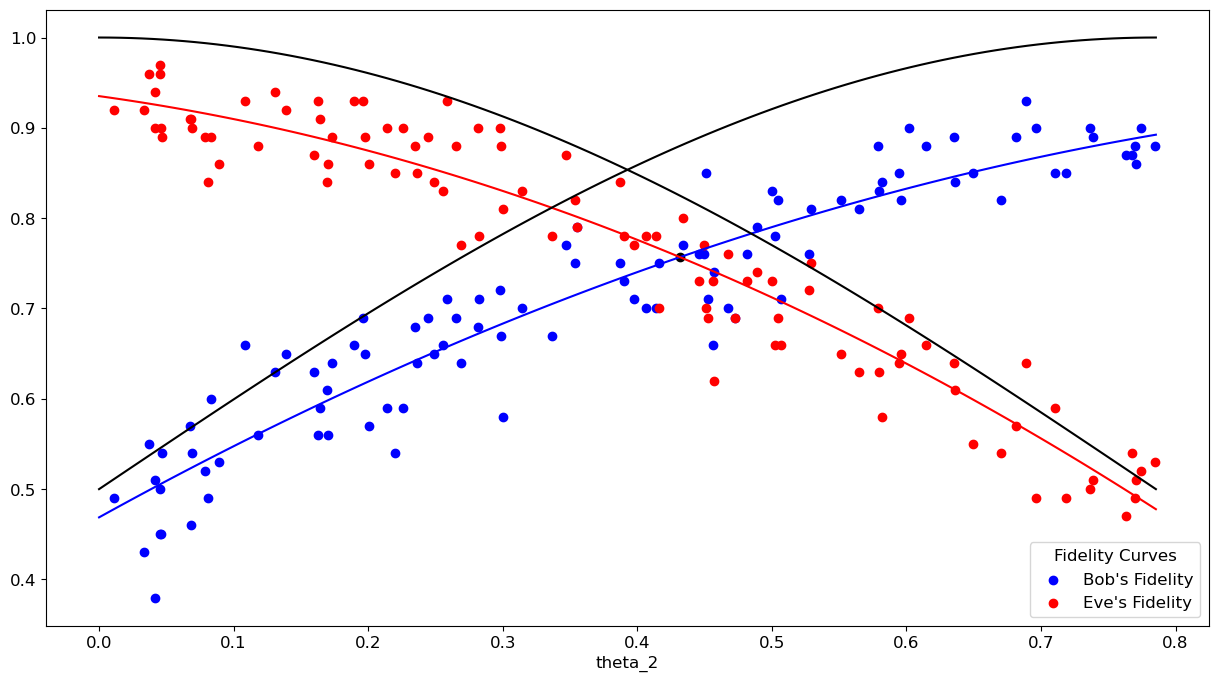

In [11]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})
plt.scatter(JobAngles, BobFid, label = "Bob's Fidelity",color='blue')
plt.scatter(JobAngles, EveFid, label = "Eve's Fidelity",color='red')
plt.scatter(theta_crit, 1- error_crit, color = 'black')
plt.plot(Thetas, Model_Bob_curve, color = 'blue')
plt.plot(Thetas, Model_Eve_curve, color = 'red')
plt.plot(Thetas, BobFid_Theory, color = 'black')
plt.plot(Thetas, EveFid_Theory, color = 'black')
#plt.yticks(np.arange(0,1.1, step = .1))
#plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Fidelity Curves")
plt.xlabel('theta_2')
plt.show()

In [12]:
print(Bob_cov)

[[ 0.00941943 -0.00735162  0.00094549]
 [-0.00735162  0.00613999 -0.00088676]
 [ 0.00094549 -0.00088676  0.00017069]]


In [13]:
print(Eve_cov)

[[ 0.00723298 -0.00564515  0.00072602]
 [-0.00564515  0.00471477 -0.00068092]
 [ 0.00072602 -0.00068092  0.00013107]]


In [14]:
Bob_sigma = np.sqrt(np.diag(Bob_cov))
Eve_sigma = np.sqrt(np.diag(Eve_cov))

In [18]:
len(Bob_sigma)

3

In [15]:
print(Bob_sigma)
print(Eve_sigma)

[0.09705374 0.0783581  0.01306466]
[0.08504692 0.06866417 0.01144839]


In [16]:
print(Bob_coeffs)

[-0.36172422  0.82351801  0.46875059]


In [17]:
print(Eve_coeffs)

[-0.47871889 -0.20632361  0.93512551]


In [23]:
def intersection_stats(Bob_sigma, Bob_coeffs, Eve_sigma, Eve_coeffs, N):
    k = len(Bob_sigma)
    theta_vals = np.zeros(N)
    error_vals = np.zeros(N)
    
    # select coeffs for Bob
    Bob0 = np.random.normal(Bob_coeffs[0], Bob_sigma[0], N)
    Bob1 = np.random.normal(Bob_coeffs[1], Bob_sigma[1], N)
    Bob2 = np.random.normal(Bob_coeffs[2], Bob_sigma[2], N)
    
    
    # select coeffs for Eve
    Eve0 = np.random.normal(Eve_coeffs[0], Eve_sigma[0], N)
    Eve1 = np.random.normal(Eve_coeffs[1], Eve_sigma[1], N)
    Eve2 = np.random.normal(Eve_coeffs[2], Eve_sigma[2], N)
    
    
    # build polynomails accordingly and find their intersection points
    for j in range(N):
        BobMod = np.array([Bob0[j], Bob1[j], Bob2[j]])
        EveMod = np.array([Eve0[j], Eve1[j], Eve2[j]])
        
        BobPoly = np.poly1d(BobMod)
        EvePoly = np.poly1d(EveMod)
        
        ModelDiff = BobPoly - EvePoly
        Roots = np.roots(ModelDiff)
        RealRoots = Roots[~np.iscomplex(Roots)]
        for k in range(len(RealRoots)):
            if RealRoots[k] >= 0 and RealRoots[k] <= np.pi/4:
                theta_vals[j] = RealRoots[k]
                error_vals[j] = 1 - BobPoly(RealRoots[k])
                        
    
    return theta_vals, error_vals

In [44]:
theta_vals, error_vals = intersection_stats(Bob_sigma, Bob_coeffs, Eve_sigma, Eve_coeffs, 10000)

In [25]:
for j in range(100):
    print("Angle = ", theta_vals[j], "Error = ", error_vals[j])

Angle =  0.4312975065025106 Error =  0.21637088089925582
Angle =  0.4351196865626457 Error =  0.24603531316147953
Angle =  0.36515899403110597 Error =  0.227662230646283
Angle =  0.4631323681024783 Error =  0.24297448124642018
Angle =  0.41413380524394167 Error =  0.2759438987928624
Angle =  0.3984428273999589 Error =  0.27442763217702826
Angle =  0.421921636605038 Error =  0.23294679764572657
Angle =  0.36807194702200374 Error =  0.18788655025224865
Angle =  0.4430402372799855 Error =  0.2119079612480912
Angle =  0.495758948635013 Error =  0.2170433721891094
Angle =  0.44510070497200965 Error =  0.28452109012434534
Angle =  0.4481159646809215 Error =  0.2489804836927083
Angle =  0.428424217817681 Error =  0.2870153411253733
Angle =  0.39207651371734137 Error =  0.23463006346895798
Angle =  0.42748491043354647 Error =  0.2172888870436669
Angle =  0.3859500102665922 Error =  0.25821886867425925
Angle =  0.5139771461496567 Error =  0.2598032989969459
Angle =  0.4221264794014269 Error =  

From this we now want to calculate confidence intervals for the error and the angle.

In [45]:
mean_angle = np.mean(theta_vals)
mean_error = np.mean(error_vals)

In [46]:
def mean_confidence_interval(data, confidence):
    N = len(data)
    mean = np.mean(data)
    std_error = scipy.stats.sem(data)
    h = std_error * scipy.stats.t.ppf((1 + confidence)/2., N-1)
    return mean, mean - h, mean + h

In [47]:
angle_confidence_interval = mean_confidence_interval(theta_vals, 0.95)
error_confidence_interval = mean_confidence_interval(error_vals, 0.95)

In [48]:
print(angle_confidence_interval)

(0.43797357148434146, 0.43697215136867174, 0.4389749916000112)


In [49]:
print(error_confidence_interval)

(0.24465534188443416, 0.24409226189219924, 0.2452184218766691)
